In [55]:
import warnings
import json

import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns

from jre_utils.process import get_most_active_municipalities
from jre_utils.datapath import model_ready_data_paths, DATA_DIRECTORY_PATH

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [56]:
n_neighbours = 5
neighbours_path = f"{DATA_DIRECTORY_PATH}/neighbours/{n_neighbours}.json"
with open(neighbours_path) as fd:
    neighbours = json.load(fd)
    print(f"E.g. Maps 1100 to {list(neighbours['1100'].keys())}")

E.g. Maps 1100 to ['1203', '1234', '1217', '1423', '1231']


In [57]:
# get weighted average prices of the neighbour of an area_code and year
def get_weighted_average_neighbour_prices(df, area_code, year, price_column):
    nd = neighbours[area_code]
    filtered_df = df[(df["year"] == year) & (df["area_code"].isin(nd.keys()))]
    returns_dict = filtered_df.set_index("area_code")[price_column].dropna().to_dict()

    if len(returns_dict) == 0:
        return 0

    returns = [returns_dict.get(key, 0) for key in nd.keys()]
    weights = [1 if returns_dict.get(key, None) else 0 for key, distance in nd.items()]

    # weights = [np.log(1 / max(0.01, distance)) for distance in nd.values()]

    return np.average(returns, weights=weights)

In [136]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 4

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
    "robust": "robust_price_index",
    "ols": "ols_price_index",
}

# granularity_columns = ["area", "area_code"]
granularity_columns = ["area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "robust"
metric = metrics[metric_key]
metric_sharpe = metric + "_sharpe"

In [69]:
investment_asset_type = "building"

In [70]:
dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
model_ready_data_path = model_ready_data_paths[dataset_name]

In [71]:
core_df = pd.read_csv(model_ready_data_path)
core_df["area_code"] = core_df["area_code"].astype(str)
core_df["noise"] = np.random.normal(0, 1, core_df.shape[0])
core_df["yearly_return"] = core_df[f"{investment_asset_type}_yearly_price_growth"]
core_df["sharpe"] = core_df.groupby(granularity_columns)[
    f"building_{metric_sharpe}"
].shift(-years_ahead)
core_df["neighbour_return"] = core_df.apply(
    lambda x: get_weighted_average_neighbour_prices(
        core_df, x["area_code"], x["year"], "yearly_return"
    ),
    axis=1,
)

In [137]:
from jre_utils.process import get_cumulative_growth
from jre_utils.visualize import plot_time_series


area_codes = ["13103", "1100", "12238"]
area_df = core_df[core_df["area_code"].isin(area_codes)].sort_values(by="year", ascending=True)

area_df[f"cumulative_neighbour_return"] = get_cumulative_growth(
    area_df.copy(), "neighbour_return"
)

color_map = {
    "13103": "#03045e",
    "1100": "#0077b6",
    "12238": "#00b4d8",
}

plot_time_series(
    area_df,
    f"cumulative_neighbour_return",
    group_by_columns,
    granularity_columns,
    f"Price Index over time",
    # visible="legendonly",
    width=1000,
    height=600,
    # highlight=True,
    # highlight_range=(2020, 2022)
    color_discrete_map=color_map
)

core_df[core_df["area_code"] == "13101"][["year", "area_code", "area", "neighbour_return"]].round(3).to_csv("neighbour_return.csv")

In [77]:
engineering_columns = [
    "net_migration_ratio",
    "taxable_income_growth",
    "new_dwellings_ratio",
    "yearly_return",
    "neighbour_return",
    "noise",
]

engineered_columns = []

for col in engineering_columns:
    core_df["multiplier"] = core_df[col] + 1
    core_df[f"cumu3_{col}"] = core_df.groupby(granularity_columns)[
        "multiplier"
    ].transform(lambda x: x.rolling(3, 1).apply(np.prod, raw=True))
    engineered_columns.append(f"cumu3_{col}")
    print(f"cumu3_{col}")

print()

cumu3_net_migration_ratio
cumu3_taxable_income_growth
cumu3_new_dwellings_ratio
cumu3_yearly_return
cumu3_neighbour_return
cumu3_noise



In [78]:
# normalize the log, don't log the normalized

for factor in engineered_columns:
    core_df[f"normalized_{factor}"] = core_df.groupby("year")[factor].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    
    core_df[f"log_{factor}"] = np.log(core_df[factor] + 1)
    core_df[f"normalized_log_{factor}"] = core_df.groupby("year")[
        f"log_{factor}"
    ].transform(lambda x: (x - x.mean()) / x.std())
    
core_df[f"normalized_sharpe"] = core_df.groupby("year")[
    f"sharpe"
].transform(lambda x: (x - x.mean()) / x.std())


In [80]:
core_df[core_df["area_code"] == "13101"][
    [
        "year",
        "area_code",
        "taxable_income_growth",
        "cumu3_net_migration_ratio",
        "sharpe",
        "normalized_sharpe",
        f"building_{metric_sharpe}",
    ]
]

year area_code  taxable_income_growth  cumu3_net_migration_ratio  \
14857  2006     13101               0.096990                   1.019416   
14858  2007     13101               0.106918                   1.028177   
14859  2008     13101               0.068980                   1.039215   
14860  2009     13101              -0.086969                   1.039791   
14861  2010     13101              -0.034085                   1.043899   
14862  2011     13101               0.075307                   1.046359   
14863  2012     13101              -0.060839                   1.046325   
14864  2013     13101               0.062684                   1.069863   
14865  2014     13101               0.203222                   1.101891   
14866  2015     13101              -0.002293                   1.105401   
14867  2016     13101               0.123044                   1.083104   
14868  2017     13101               0.061411                   1.056194   
14869  2018     13101               0.086993                   1.065500   
14870  2019     13101               0.138419                   1.079821   
14871  2020     13101              -0.028845                   1.076727   
14872  2021     13101              -0.006847                   1.042108   
14873  2022     13101                    NaN                   1.016923   

         sharpe  normalized_sharpe  building_robust_price_index_sharpe  
14857 -0.090943           0.464153                                 NaN  
14858 -0.594925          -0.432722                                 NaN  
14859 -0.443349          -0.206706                                 NaN  
14860  0.271467           0.807272                                 NaN  
14861  0.337475           1.280937                           -0.090943  
14862  1.278100           3.090719                           -0.594925  
14863  1.523935           2.859899                           -0.443349  
14864  1.564900           3.070648                            0.271467  
14865  0.982863           1.497197                            0.337475  
14866  0.729099           1.127712                            1.278100  
14867  0.728049           1.343760                            1.523935  
14868  0.063853          -0.147915                            1.564900  
14869  0.247299           0.036169                            0.982863  
14870       NaN                NaN                            0.729099  
14871       NaN                NaN                            0.728049  
14872       NaN                NaN                            0.063853  
14873       NaN                NaN                            0.247299

In [81]:
def get_return_name(return_name, normalized=False, log=False):
    normalized = f"{'normalized_' if normalized else ''}"
    log = f"{'log_' if log else ''}"
    return f"{normalized}{log}{return_name}"


def get_column_name(
    fator_name,
    normalized=False,
    log=False,
    cumulative=True,
):
    normalized = "normalized_" if normalized else ""
    log = "log_" if log else ""
    cumulative = f"cumu3_" if cumulative else ""
    return f"{normalized}{log}{cumulative}{fator_name}"

In [82]:
# n = 500

# columns = [
#     "new_dwellings_ratio",
#     "net_migration_ratio",
#     "taxable_income_growth",
#     "yearly_return",
#     "neighbour_return",
# ]

# for column in columns:
#     y_col = get_return_name("sharpe", normalized=False, log=False)
#     factor = get_column_name(
#         column, cumulative=True, normalized=True, log=True, inverse=False
#     )
#     factor_columns = [factor, "noise"]
#     test_df = core_df[
#         ["year", "area_code"] + ["population"] + [y_col] + factor_columns  # for filtering
#     ]
#     test_df = test_df.dropna()
#     # test_df = get_most_active_municipalities(test_df, count_column=f"population", n=n)

#     X = test_df[factor_columns]
#     y = test_df[y_col]

#     # Add a constant to the model (the intercept)
#     X = sm.add_constant(X)

#     # Fit the OLS model
#     model = sm.OLS(y, X).fit()
#     print(model.summary())

In [83]:
# for column in columns:
#     y_col = get_return_name("sharpe", normalized=False, log=False)
#     factor = get_column_name(
#         column, cumulative=True, normalized=True, log=True, inverse=False
#     )
    
#     factor_columns = [factor, "noise"]
#     test_df = core_df[
#         ["year", "area_code"] + ["population"] + [y_col] + factor_columns  # for filtering
#     ]
#     test_df = test_df.dropna()
#     test_df = get_most_active_municipalities(test_df, count_column=f"population", n=n)

#     plot_df = test_df

#     _ = sns.pairplot(
#         x_vars=[factor, y_col],
#         y_vars=[factor, y_col],
#         data=plot_df,
#         kind="reg",
#         diag_kind="kde",
#         size=10,
#         aspect=1.8,
#     )

In [129]:
n = 500
y_col = get_return_name("sharpe", normalized=True, log=False)


columns = [
    # "new_dwellings_ratio",
    # "net_migration_ratio",
    "taxable_income_growth",
    # "yearly_return",
    # "neighbour_return",
]

factor_columns = [
    get_column_name(column, cumulative=True, normalized=True, log=True)
    for column in columns
] + ["noise"]

test_df = core_df[
    ["year", "area_code"] + ["population"] + [y_col] + factor_columns  # for filtering
]

# test_df = test_df[test_df["year"] > 2014]

test_df = test_df.dropna()
test_df = get_most_active_municipalities(test_df, count_column=f"population", n=n)
# test_df = test_df[test_df[factor] < 7]
test_df

year area_code    population  normalized_sharpe  \
15     2008     23232  61338.082822          -1.435380   
16     2009     23232  61734.146159          -1.333285   
17     2010     23232  61910.000000          -1.084162   
18     2011     23232  62000.000000          -0.905700   
19     2012     23232  61807.000000          -0.495324   
...     ...       ...           ...                ...   
16750  2014     19208  69860.000000          -0.030677   
16751  2015     19208  69830.000000          -0.090469   
16752  2016     19208  69688.000000          -0.617458   
16753  2017     19208  69596.000000           0.292057   
16754  2018     19208  69562.000000           0.186716   

       normalized_log_cumu3_taxable_income_growth     noise  
15                                      -0.016029  2.298843  
16                                       0.093174 -0.882812  
17                                      -0.456231  0.284068  
18                                      -0.903462  0.375279  
19                                      -0.614262 -0.884238  
...                                           ...       ...  
16750                                   -0.514063 -1.856519  
16751                                   -0.199698 -0.995517  
16752                                   -0.256117  1.075290  
16753                                    0.138944  0.183908  
16754                                    0.116273  3.245362  

[5706 rows x 6 columns]

In [131]:
X = test_df[factor_columns]
y = test_df[y_col]

# Add a constant to the model (the intercept)
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      normalized_sharpe   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     68.02
Date:                Sun, 07 Apr 2024   Prob (F-statistic):           6.40e-30
Time:                        12:32:53   Log-Likelihood:                -8823.9
No. Observations:                5706   AIC:                         1.765e+04
Df Residuals:                    5703   BIC:                         1.767e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------

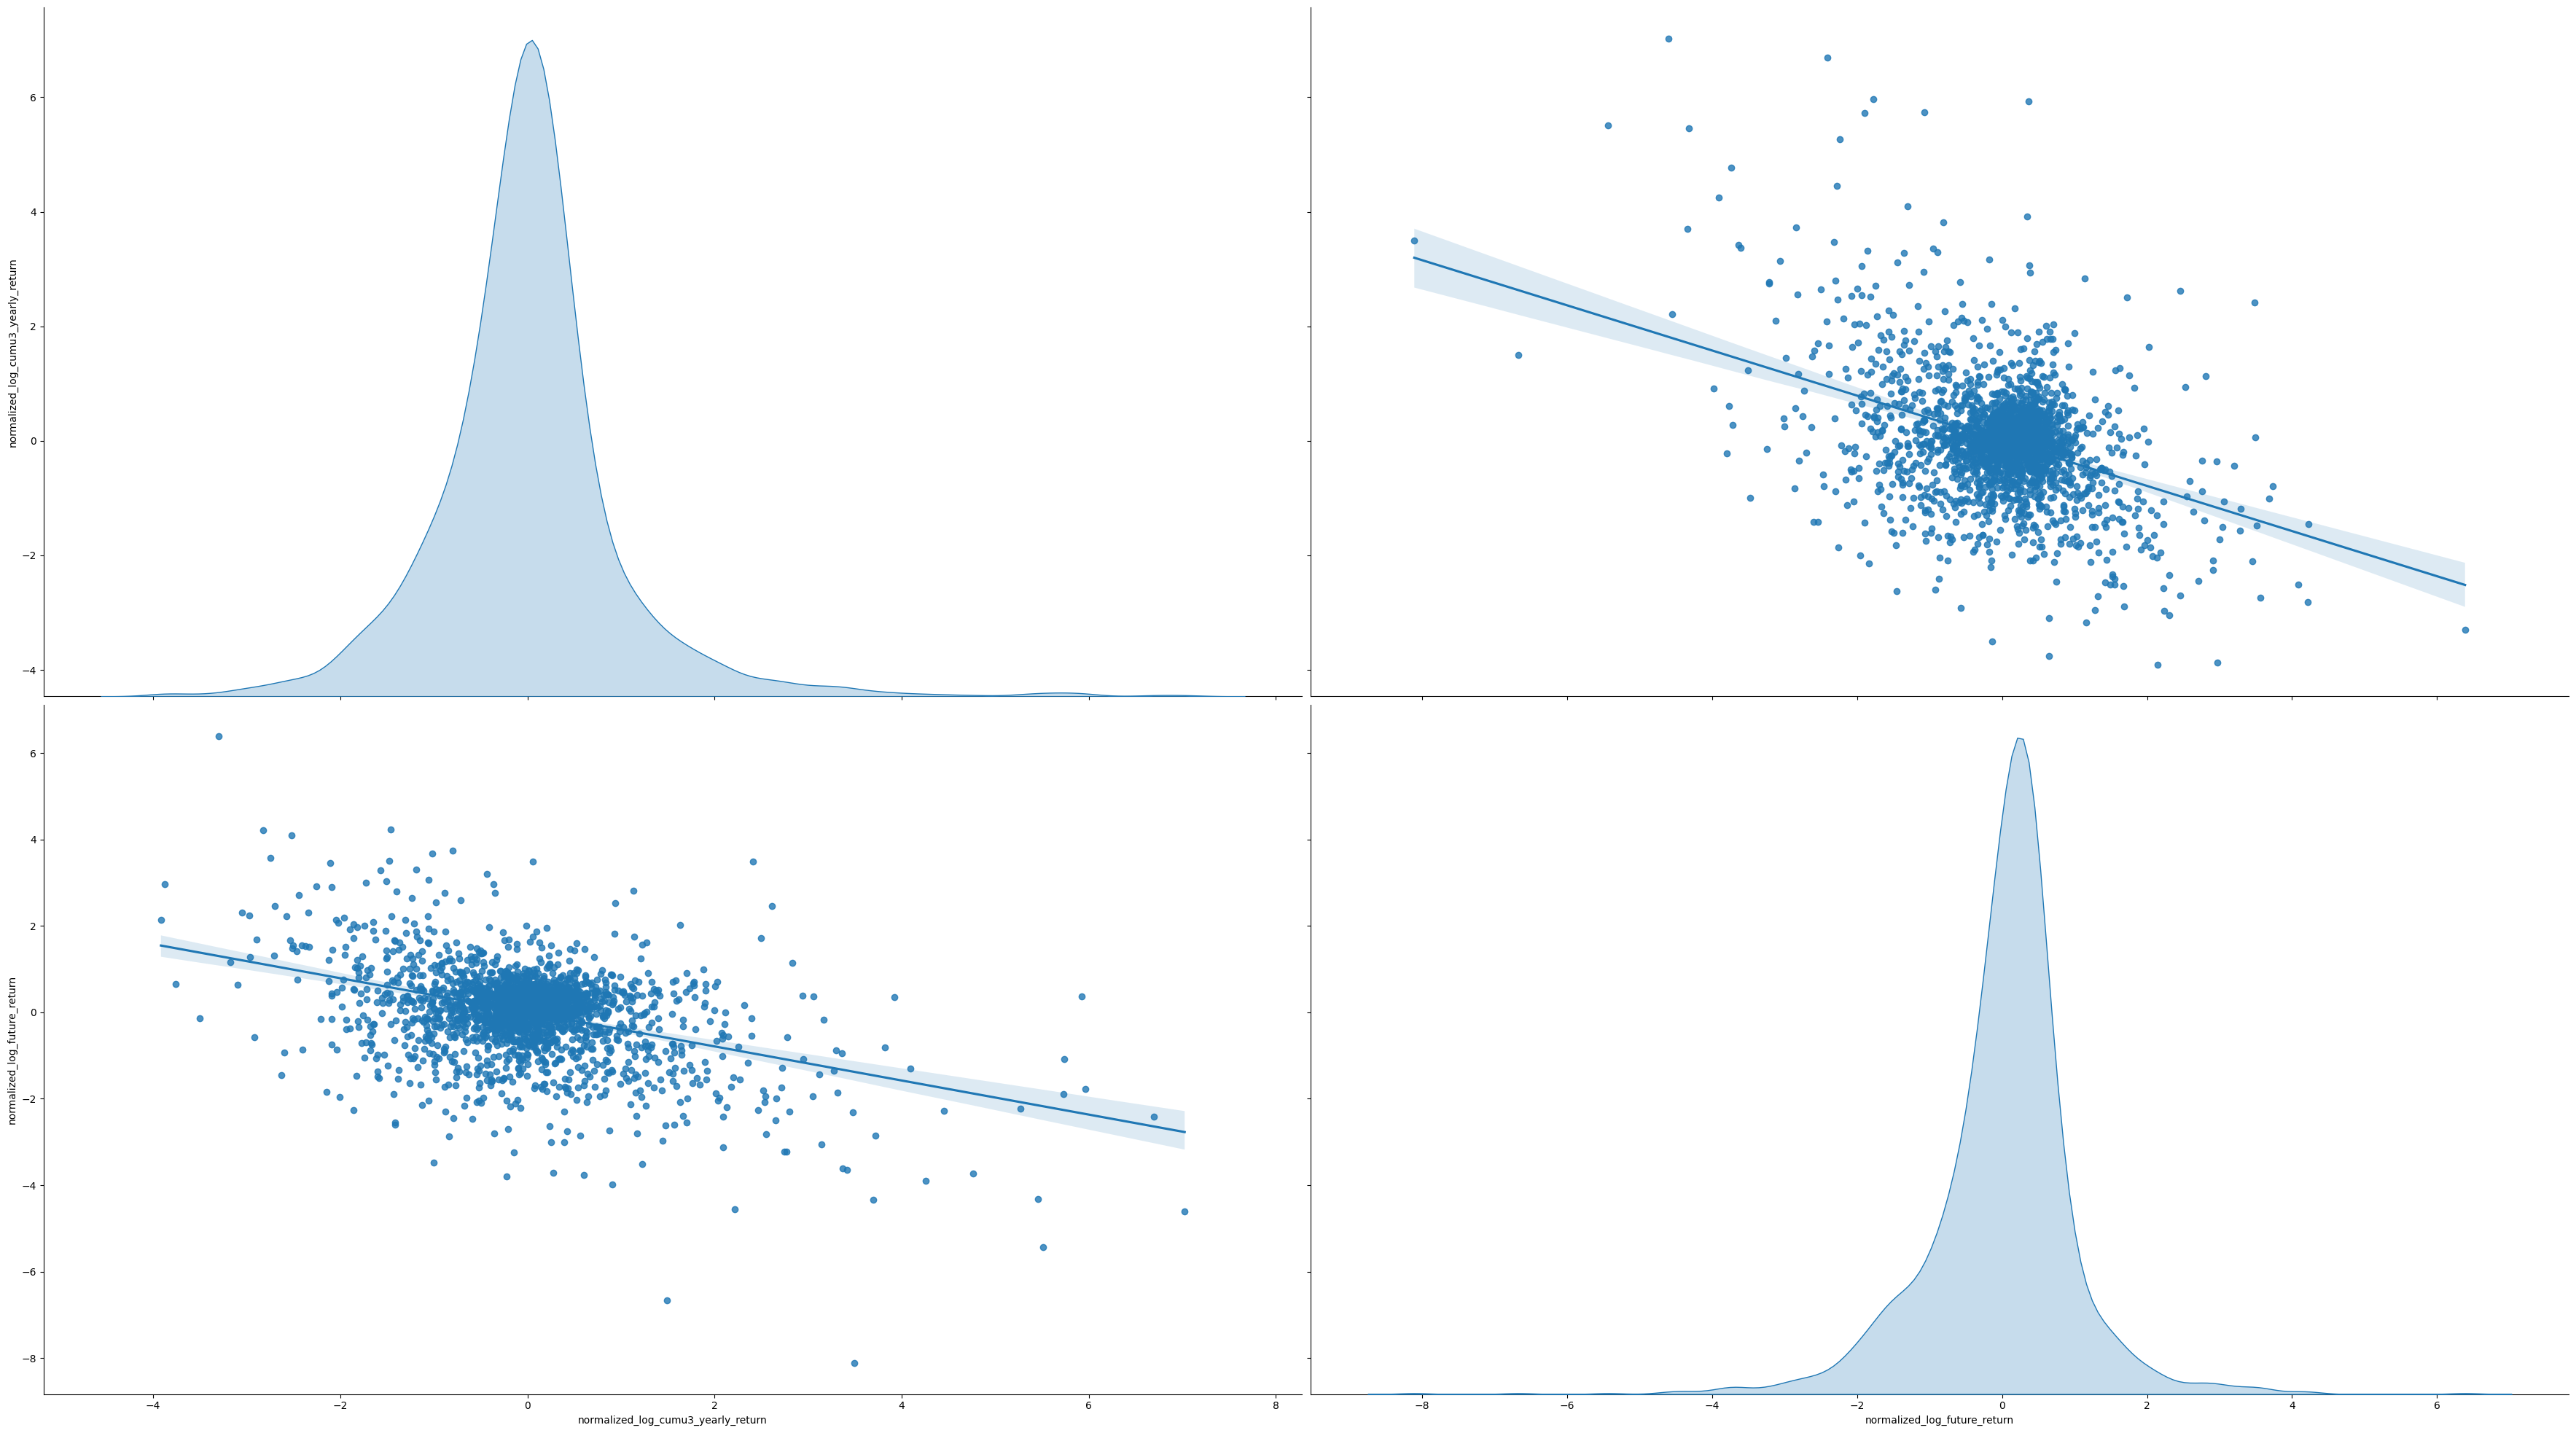

In [40]:
prefecture = 13
test_df["area_code"] = test_df["area_code"].astype(int)
prefecture_df = test_df[(test_df["area_code"] // 1000) == prefecture]
plot_df = test_df

_ = sns.pairplot(
    x_vars=[factor, y_col],
    y_vars=[factor, y_col],
    data=plot_df,
    kind="reg",
    diag_kind="kde",
    size=10,
    aspect=1.8,
)

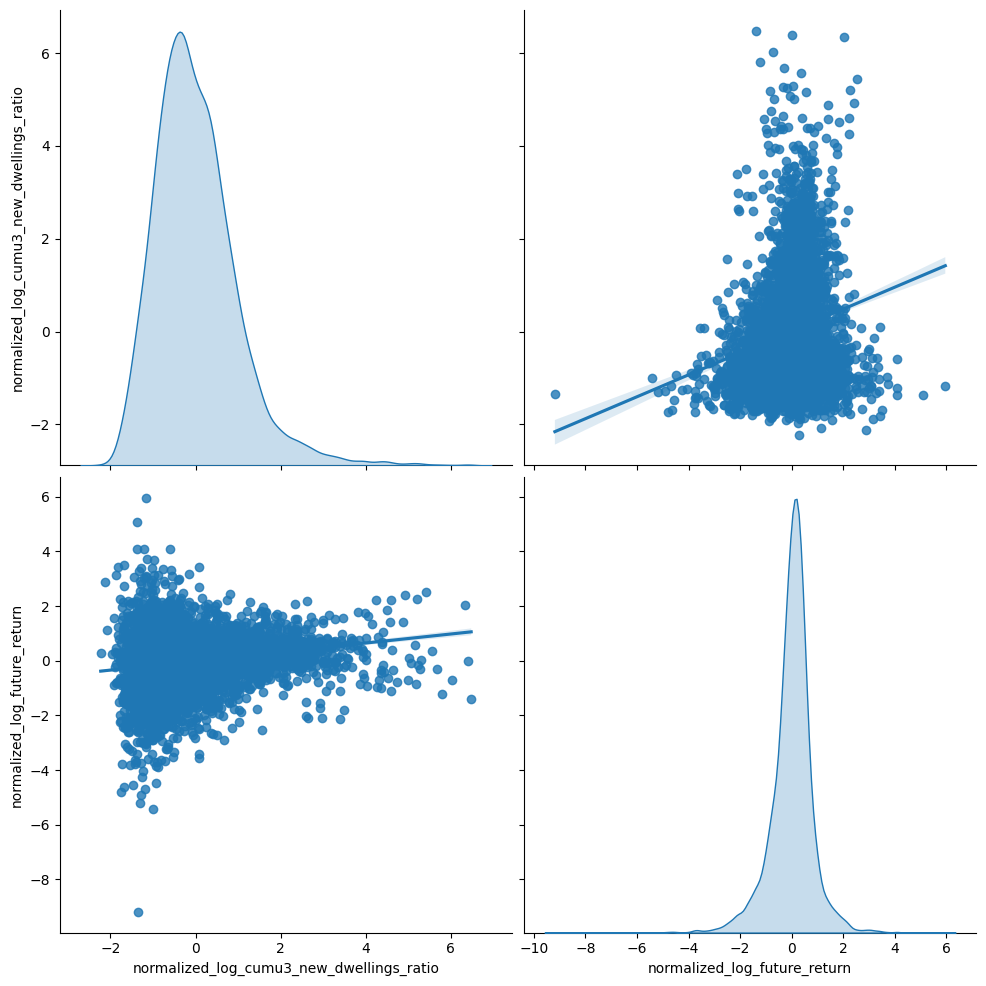

In [28]:
prefecture = 13
test_df["area_code"] = test_df["area_code"].astype(int)
prefecture_df = test_df[(test_df["area_code"] // 1000) == prefecture]
test_df = test_df

_ = sns.pairplot(
    x_vars=[factor, y_col],
    y_vars=[factor, y_col],
    data=test_df,
    kind="reg",
    diag_kind="kde",
    size=5,
    aspect=1,
)

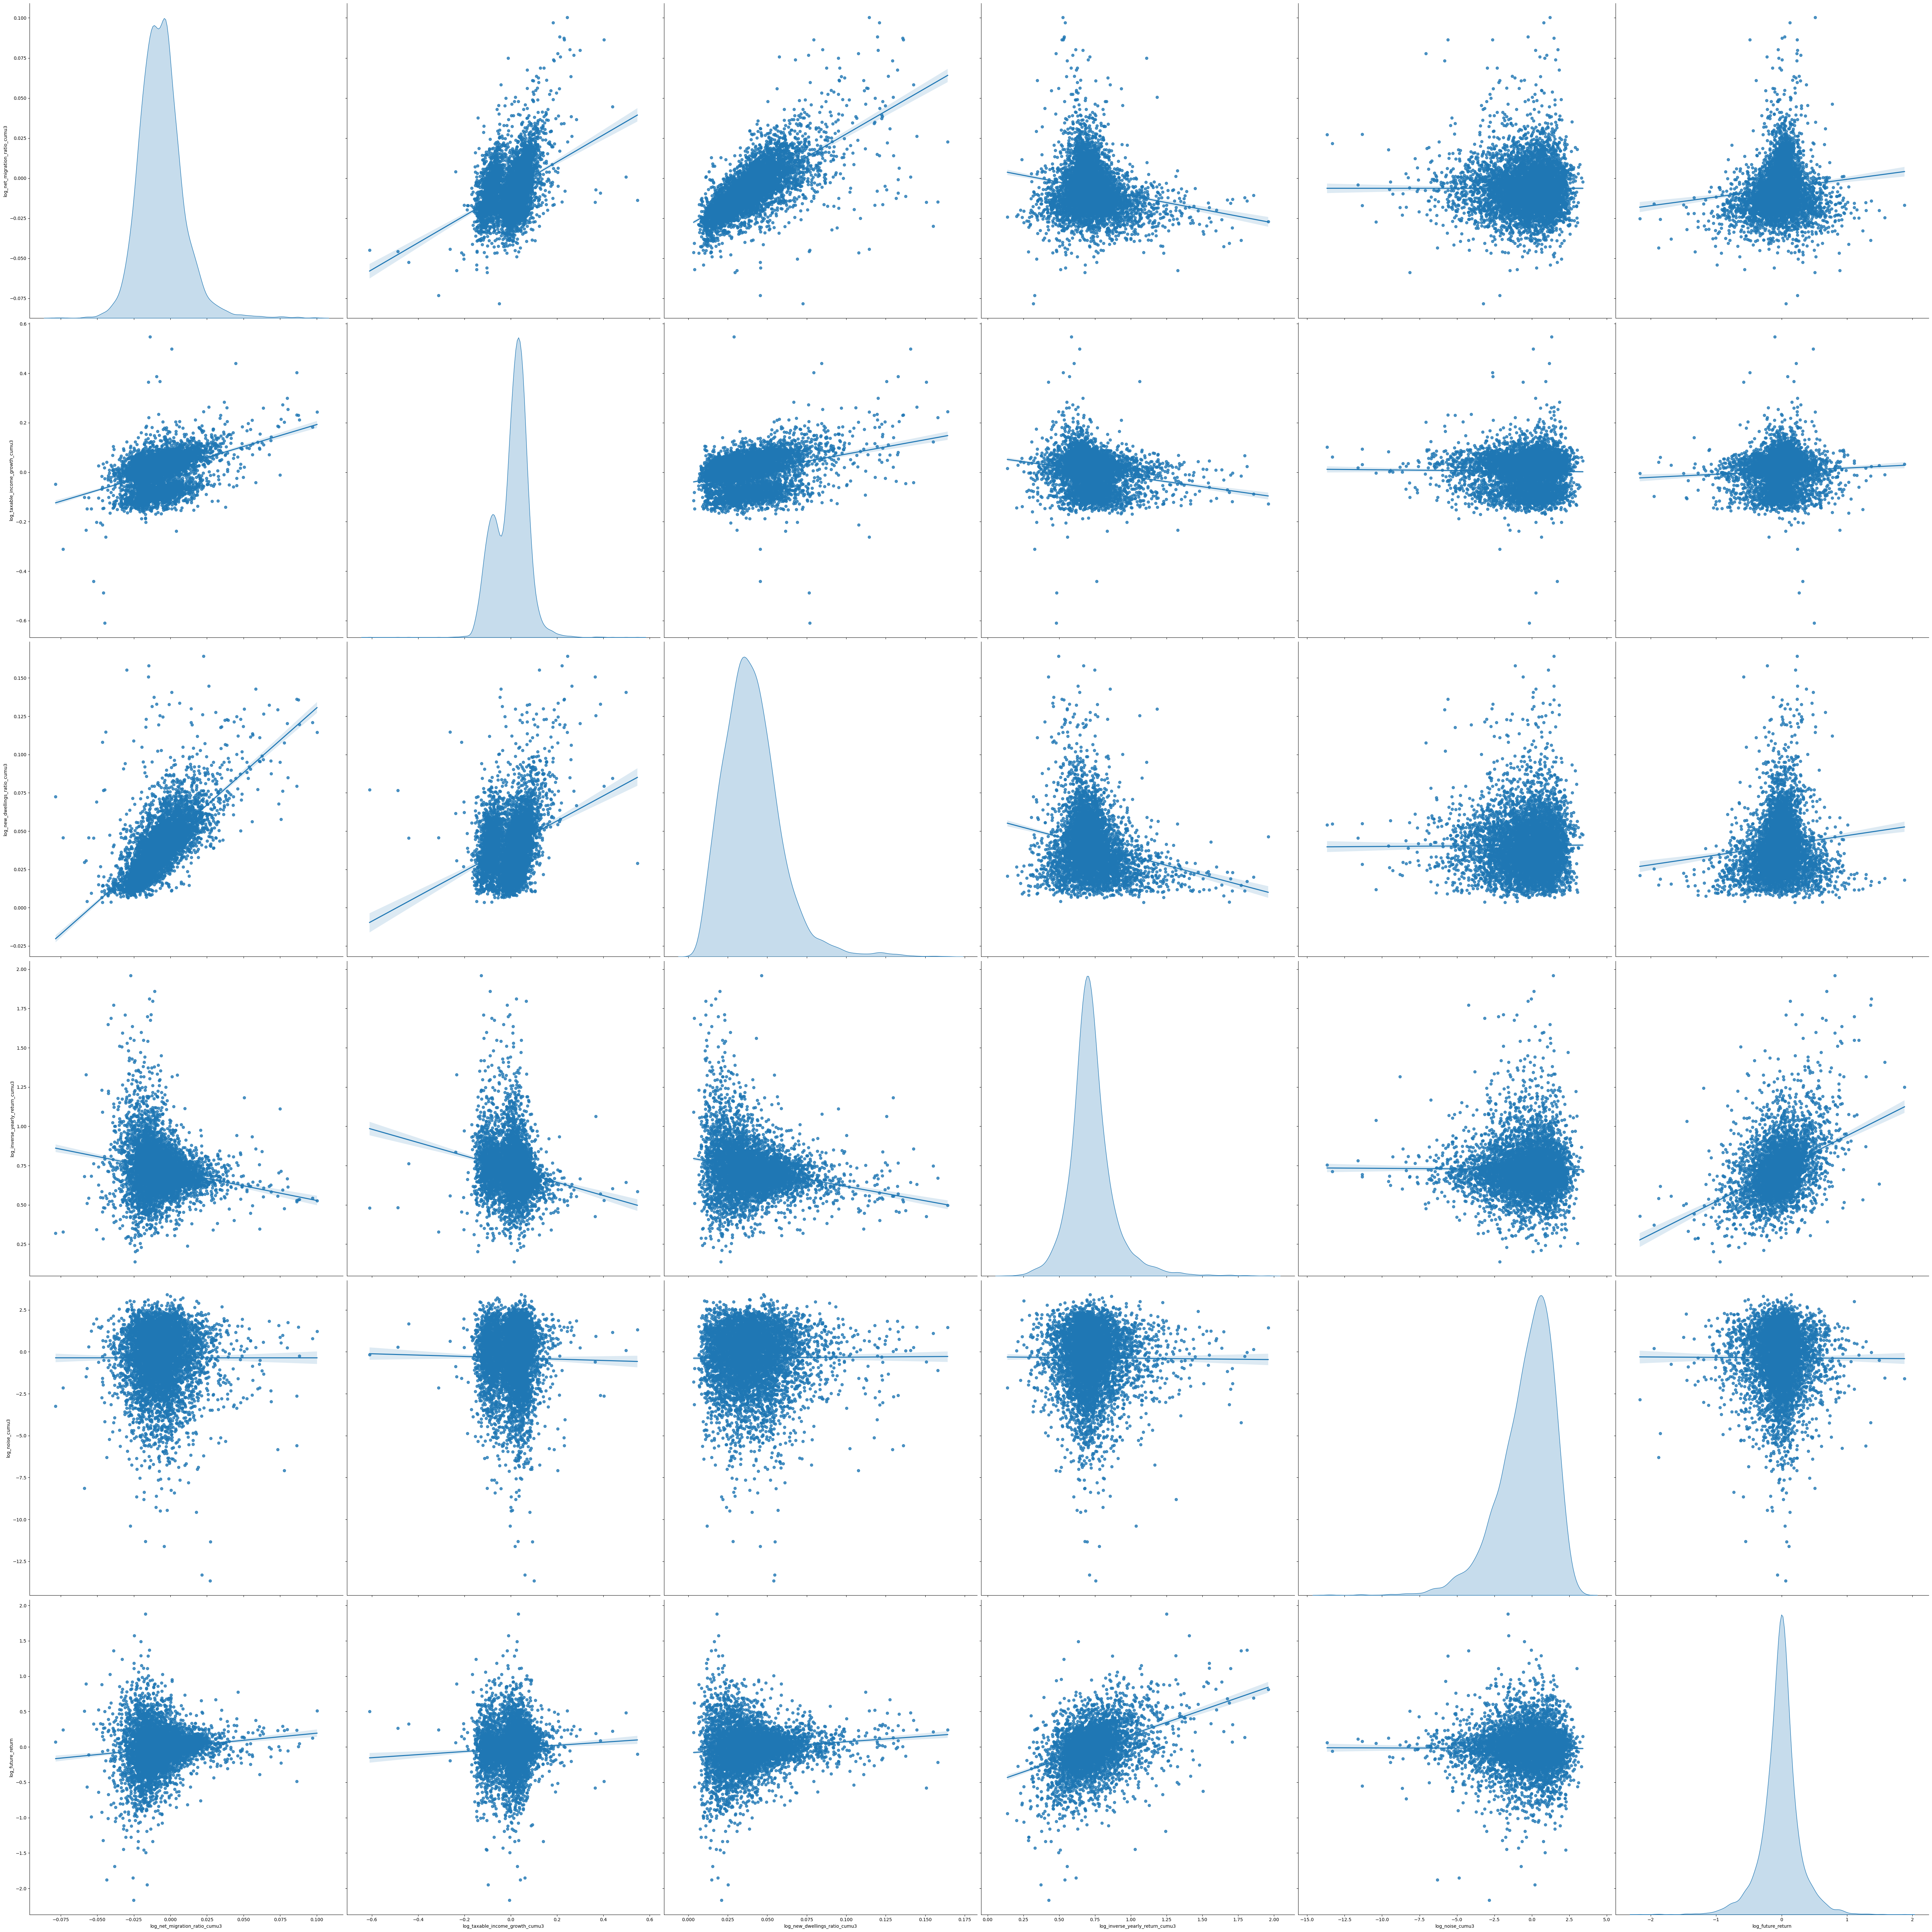

In [617]:
factor_columns = [
    "log_net_migration_ratio_cumu3",
    "log_taxable_income_growth_cumu3",
    "log_new_dwellings_ratio_cumu3",
    "log_inverse_yearly_return_cumu3",
    "log_noise_cumu3",
]

# _ = sns.pairplot(test_df[factor_columns + ["log_future_return"]], kind="reg", diag_kind="kde", size=10)

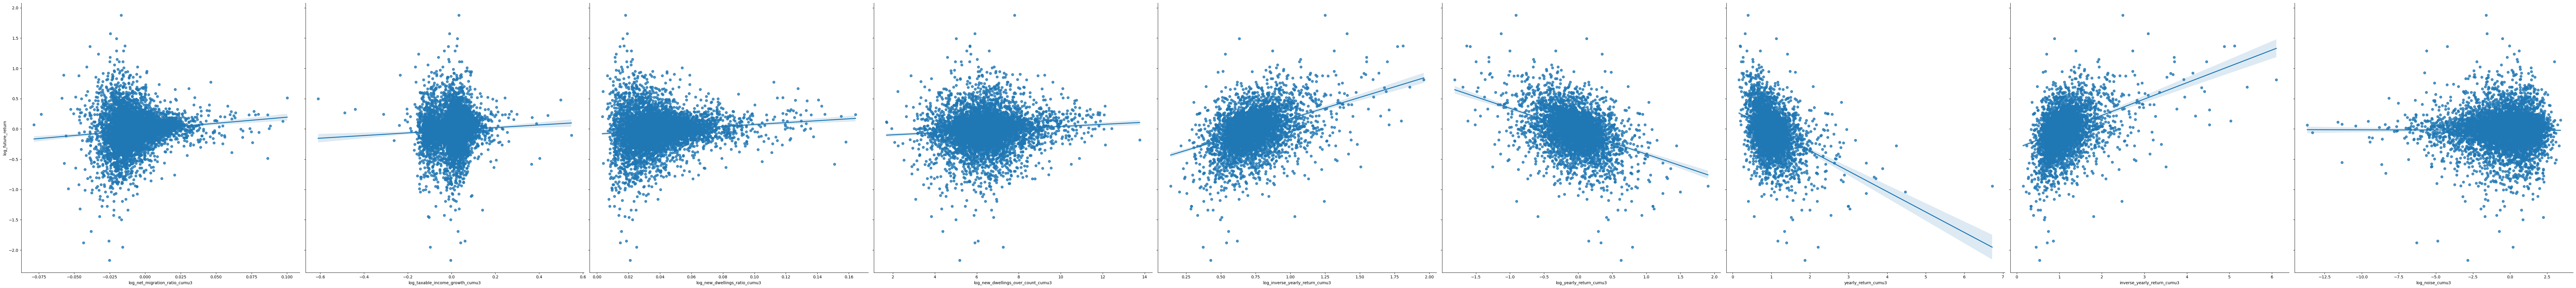

In [610]:
factor_columns = [
    "log_net_migration_ratio_cumu3",
    "log_taxable_income_growth_cumu3",
    "log_new_dwellings_ratio_cumu3",
    "log_new_dwellings_over_count_cumu3",
    "log_inverse_yearly_return_cumu3",
    "log_yearly_return_cumu3",
    "yearly_return_cumu3",
    "inverse_yearly_return_cumu3",
    "log_noise_cumu3",
]

_ = sns.pairplot(
    test_df,
    y_vars=["log_future_return"],
    x_vars=factor_columns,
    kind="reg",
    diag_kind="kde",
    size=10,
)

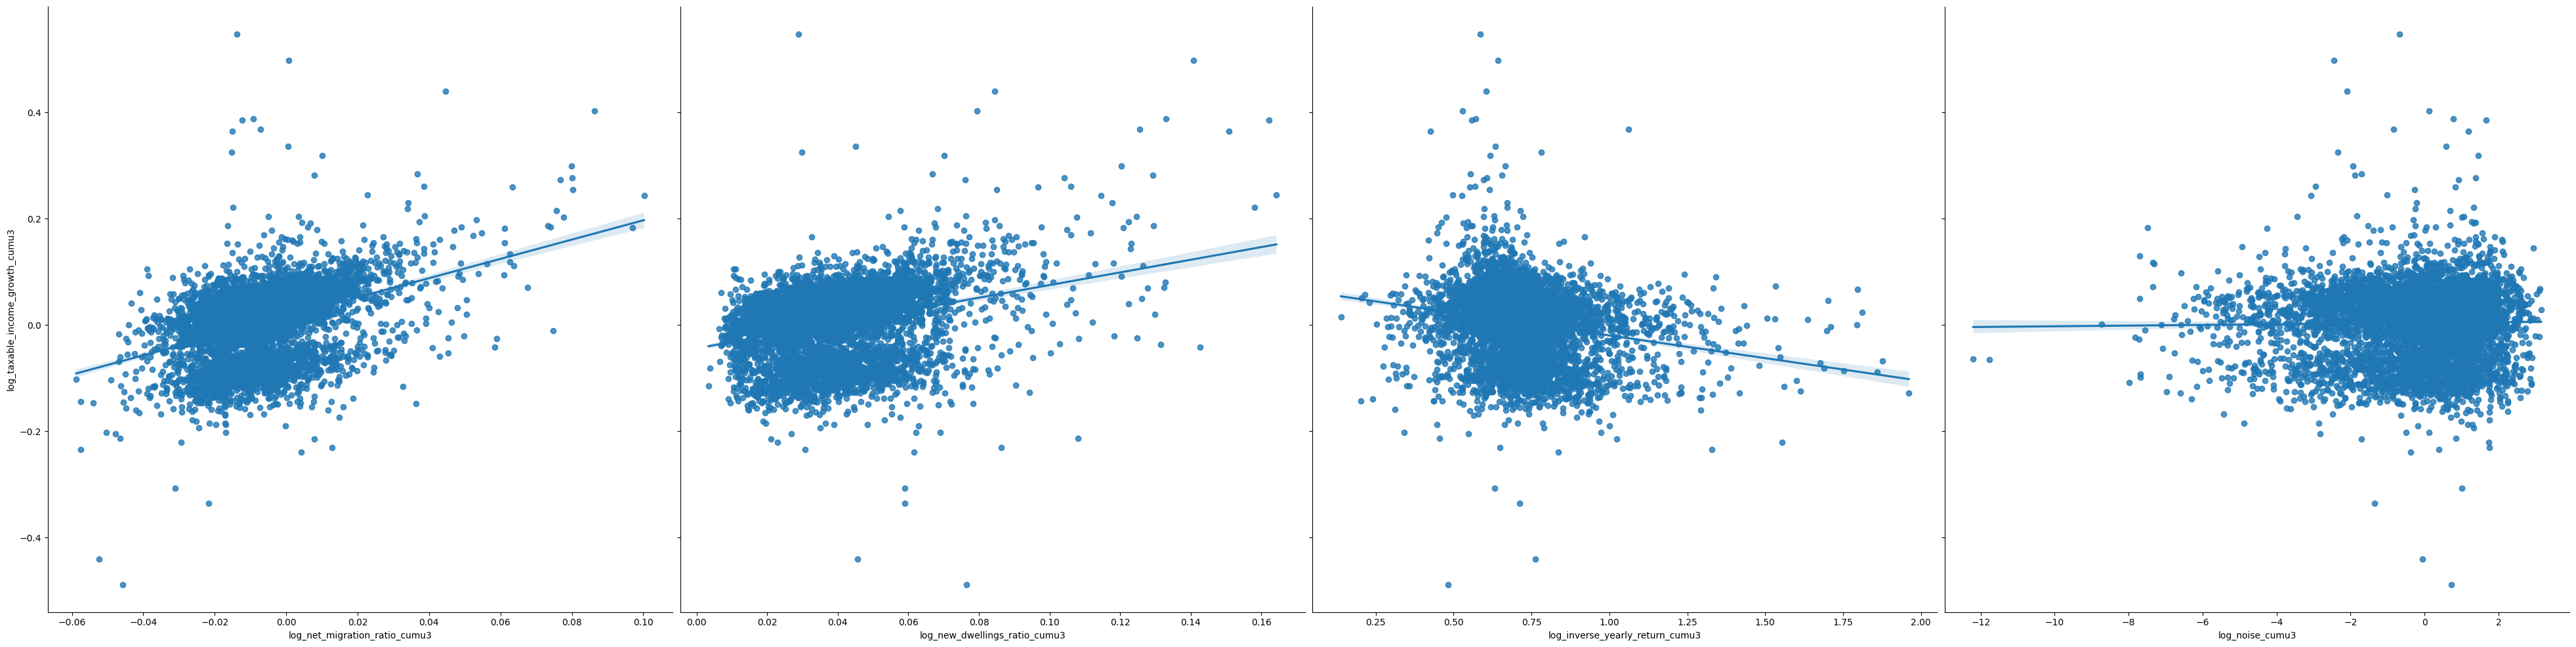

In [552]:
factor_columns = [
    "log_net_migration_ratio_cumu3",
    "log_new_dwellings_ratio_cumu3",
    "log_inverse_yearly_return_cumu3",
    "log_noise_cumu3",
]

_ = sns.pairplot(
    test_df,
    y_vars=["log_taxable_income_growth_cumu3"],
    x_vars=factor_columns,
    kind="reg",
    diag_kind="kde",
    size=10,
)